## Imports and utility functions


In [10]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

import time


from random import *

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn import preprocessing
from sklearn import metrics

# from keras import backend as K
from tensorflow import keras as k
from tensorflow.keras import utils, models, layers, optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

import tensorflow as tf




In [3]:
%run standard_assessment_metrics_function.ipynb

In [4]:

def NewellCF_calc(v,bz,by):
    # v expected in km/s
    # b's expected in nT    
    NCF = np.zeros_like(v)
    NCF.fill(np.nan)
    bt = np.sqrt(by**2 + bz**2)
    bztemp = bz
    bztemp[bz == 0] = .001
    #Caculate clock angle (theta_c = t_c)
    tc = np.arctan2(by,bztemp)
    neg_tc = bt*np.cos(tc)*bz < 0 
    tc[neg_tc] = tc[neg_tc] + np.pi
    sintc = np.abs(np.sin(tc/2.))
    NCF = (v**1.33333)*(sintc**2.66667)*(bt**0.66667)
    return NCF

def nearest(items, pivot):
    #return min(items, key=lambda x: abs(x - pivot))
    return np.argmin(abs(items - pivot))


def outlier_detect_and_replace(df,str_id,outlier_value):
    """This function takes a dataframe, finds any columns 
    matching 'str_id' in the provided dataframe, and replaces
    all values that exceed the 'outlier_value' with NaN"""
#     print('working on {} outlier detection and removal'.format(str_id))
#     print('outlier value = {}'.format(outlier_value))

    cols = [ col for col in df.columns if str_id in col]
#     print('will detect and replace for columns = {}'.format(cols))
    for i in cols:
        df[i][ df[i] > outlier_value ] = np.NaN

    return df

# Metrics defined by 2019 GNSS FDL team
def dynamic_range_and_mae_loss(y_true, y_pred):
    mae = k.losses.mean_absolute_error(y_true, y_pred)
    dynamic_range_true = k.backend.max(y_true) - k.backend.min(y_true)
    dynamic_range_pred = k.backend.max(y_pred) - k.backend.min(y_pred)
    dynamic_range_loss = dynamic_range_true - dynamic_range_pred
    dynamic_range_loss = k.backend.mean(dynamic_range_loss)
    return mae + 0.1* dynamic_range_loss


In [5]:
# # NASA Laptop
# DMSP_FIGURE_DIR = '/Users/rmcgrana/Documents/DMSPdata/figures/'
# DMSP_DATA_DIR = '/Users/rmcgrana/Documents/DMSPdata/data/'

#Personal Laptop
DMSP_FIGURE_DIR = '/Users/ryanmcgranaghan/Documents/DMSPdata/figures/'
DMSP_DATA_DIR = '/Users/ryanmcgranaghan/Documents/DMSPdata/data/'

In [6]:
eflux_threshold_quantile = 99.995
eflux_threshold = .99995



##### Load the data

In [7]:
# file_load_df_cumulative = 'ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
file_load_df_cumulative = 'ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine_PCfixed.csv'
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)

cols_to_drop_featureimportance = [c for c in df_cumulative.columns if ('sin' in c) | ('cos' in c) | ('STD' in c) | ('AVG' in c)]
target_var = 'ELE_TOTAL_ENERGY_FLUX'


df_cumulative = df_cumulative.drop(columns=cols_to_drop_featureimportance)

# Construct X and y
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]

idx = np.argwhere( df_cumulative[target_var].to_numpy()>np.quantile(df_cumulative[target_var].to_numpy(),eflux_threshold) )
df_cumulative.iloc[idx,:] = np.nan
df_cumulative = df_cumulative.dropna()

numFeatures = len(df_cumulative.columns.to_list())
feature_labels = df_cumulative.columns.to_list()

Text(0, 0.5, 'nT')

<Figure size 432x288 with 0 Axes>

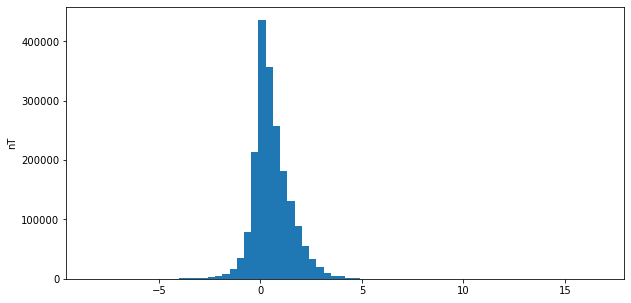

In [11]:
# Check status of PC index values
fig = plt.figure()

fig = plt.figure(figsize=(10,5))
gs = GridSpec(1,1, figure=fig)

ax0 = fig.add_subplot(gs[0,0])
ax0.hist(df_cumulative['PC'],bins = 70)
plt.ylabel('nT')


#### Feature importance examined cumulatively by year - with cross-validation and not sorting scores

In [21]:
## from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif

df_importance_columns=['cumulative up to year',
                       'number of obs',
                       'feature',
                       'median f score',
                       'mean f score',
                       'variance f score',
                       'median pca',
                       'mean pca',
                       'variance pca',
                       'median rf',
                       'mean rf',
                       'variance rf',]
                                           

flag_cumulative = 'start'


# Set values for cross-validation
n_splits = 10
bins = np.linspace(0, 15, 15)

for yr in np.arange(2014,2015):#(2007,2015):#(1987,2015):
    flag = 'start'
    
    print('year = {}'.format(yr))
    
 
    df_loop = df_cumulative.copy(deep=True)[df_cumulative.index.year <= yr]
    X = df_loop[feature_cols].copy(deep=True)
    y = df_loop[target_var].copy(deep=True)
    scaler_X = preprocessing.RobustScaler()
    scaler_X = scaler_X.fit(X.values)
    X_scaled = scaler_X.transform(X.values)
    
    
    # Create digitized y for stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, random_state=7, shuffle=False)
    y[y == 0] = 0.0001
    y_binned = np.digitize(y,
                           bins)
    
    
    # Cross-validation
    df_cv_columns = ['iter'+str(i) for i in range(10)]
    df_fscore_iter = pd.DataFrame(columns=df_cv_columns)
    df_pca_iter = pd.DataFrame(columns=df_cv_columns)
    df_rf_iter = pd.DataFrame(columns=df_cv_columns)
    ctr = 0
    for train_index, test_index in skf.split(X.values, y_binned):
#         print(train_index)
#         print(test_index)
    
        begin_time = datetime.datetime.now()
        
        print('        working on F-score iter {}...'.format(ctr))
        fSelect_model = SelectKBest(score_func=f_classif, k=X.shape[1])
        X_fSelect = fSelect_model.fit_transform(X.values[train_index],y.values[train_index]) 
        df_fscore_iter['iter'+str(ctr)] = fSelect_model.scores_

        print('        working on PCA iter {}...'.format(ctr))
        pca_all = PCA(n_components=X_scaled.shape[1])
        pca_all.fit_transform(X_scaled[train_index])

        # ID the point at which cumulative variance explained exceeds 90%
        idx_90 = np.argwhere(np.cumsum(pca_all.explained_variance_ratio_) > 0.9)
        # Calculate feature importance as:
        #   for 'feature': Sum_n_N (explained_variance(n) * principal_component(n,feature))
        #     --> where 'N' == # of PCs that capture 90% of the variance in original data
        fi_pca = [ np.sum( (pca_all.explained_variance_*np.abs(pca_all.components_[:,x]))[0:idx_90[0][0]] ) for x in range(len(pca_all.components_[0,:]))]
        df_pca_iter['iter'+str(ctr)] = fi_pca

        print('        working on Random Forest iter {}...'.format(ctr))
        rf = RandomForestRegressor(n_estimators=100, 
                                   #max_depth=100,
                                   min_samples_split=200,
                                   random_state=0,
                                   n_jobs=-1)
        rf.fit(X.values[train_index],np.log10(y.values[train_index]))
        df_rf_iter['iter'+str(ctr)] = rf.feature_importances_
        
        print('elapsed time for iteration {} = {}'.format(ctr,datetime.datetime.now() - begin_time))
        
        print('------------\n')
    
    
        ctr += 1
        

                               
    # Save ranked features and their importance scores
    df_importance = pd.DataFrame(data = np.column_stack( ((np.tile(yr,X.shape[1])),
                                                          (np.tile(X.shape[0],X.shape[1])),
                                                          X.columns.to_list(),
                                                          df_fscore_iter.median(axis=1),
                                                          df_fscore_iter.mean(axis=1),
                                                          df_fscore_iter.var(axis=1),
                                                          df_pca_iter.median(axis=1),
                                                          df_pca_iter.mean(axis=1),
                                                          df_pca_iter.var(axis=1),
                                                          df_rf_iter.median(axis=1),
                                                          df_rf_iter.mean(axis=1),
                                                          df_rf_iter.var(axis=1),)
                                                   ),
                             columns = df_importance_columns)

    df_importance.to_csv(os.path.join(DMSP_DATA_DIR,'feature_importance_withCV_cumulative_up_to_year_'+str(yr)+'_Sept2020.csv'))

    
    
    

    

year = 2014


/anaconda3/envs/python36_tf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


        working on F-score iter 0...
        working on PCA iter 0...
        working on Random Forest iter 0...
elapsed time for iteration 0 = 3:27:00.832985
------------

        working on F-score iter 1...


KeyboardInterrupt: 

##### Load the data that was calculated and saved in the above box


In [16]:
df_importance = pd.read_csv(os.path.join(DMSP_DATA_DIR,'feature_importance_withCV_cumulative_up_to_year_2014.csv'))
drop_unnamed = [col for col in df_importance.columns if ('Unnamed' in col)]
print('detected Unnamed column {}, dropping it'.format(drop_unnamed))
df_importance = df_importance.drop(columns=drop_unnamed)

# setting the features as the index
df_importance = df_importance.set_index('feature')

# # drop problematic PC index
# df_importance_noPC = df_importance.copy()

# drop_PC = [col for col in df_importance_noPC.index if ('PC' in col)]

# df_importance_noPC = df_importance_noPC.drop(drop_PC,axis=0)




detected Unnamed column ['Unnamed: 0'], dropping it


In [17]:
df_importance[df_importance.index=='PC']


,cumulative up to year,number of obs,median f score,mean f score,variance f score,median pca,mean pca,variance pca,median rf,mean rf,variance rf
feature,,,,,,,,,,,
PC,2014,295090,0.569829,5.928112,145.400332,107.356643,95.174797,1063.147709,0.001061,0.001091,1.421478e-08


In [353]:

# # convert all columns of DataFrame
# df_importance = df_importance.apply(pd.to_numeric) # convert all columns of DataFrame


#### Sort and visualize the features


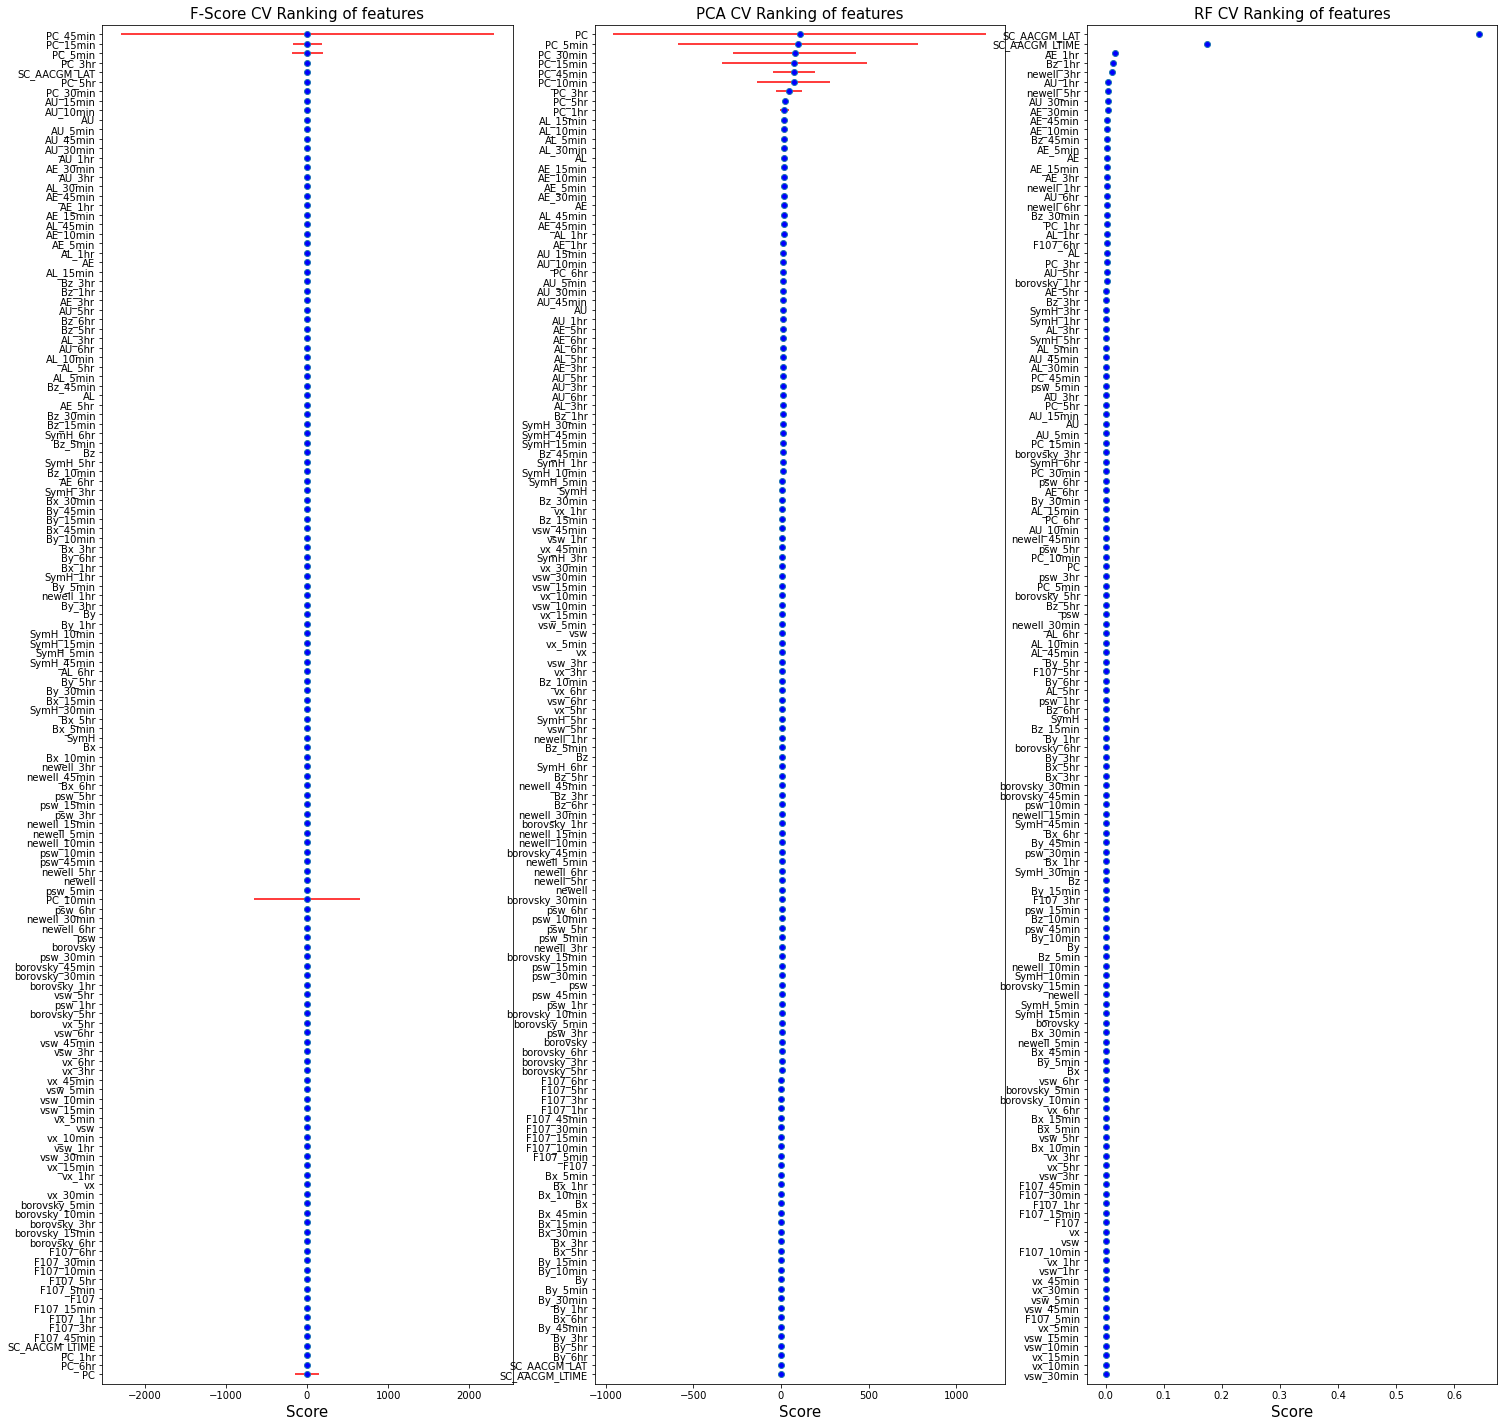

In [19]:
fig = plt.figure(figsize=(25,25))


# ----------------------------------------------------------------------------------------------------
# F SCORE
fscore_order = np.argsort(df_importance['median f score'])
fscore_orderedscores = [df_importance['median f score'][i] for i in fscore_order]
fscore_orderedvariances = [df_importance['variance f score'][i] for i in fscore_order]
# fscore_orderedfeaturelabels = [df_importance['feature'][i] for i in fscore_order]
fscore_orderedfeaturelabels = [df_importance.index[i] for i in fscore_order]
# [fscore_orderedfeaturelabels,fscore_orderedscores]


y_pos = np.arange(df_importance.shape[0])

plt.subplot(131)
plt.errorbar(fscore_orderedscores, 
             y_pos, 
             xerr=fscore_orderedvariances, 
             fmt='o',
             ecolor='r',
             mfc='b')
plt.ylim((-1, len(y_pos)))
plt.yticks(y_pos, fscore_orderedfeaturelabels)
plt.xlabel('Score', fontsize=15)
plt.title('F-Score CV Ranking of features', fontsize=15)
fig = plt.gcf()
#fig.savefig('features_FisherScores.png',bbox_inches='tight')
# ----------------------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------------------
# PCA SCORE
plt.subplot(132)
pca_order = np.argsort(df_importance['median pca'])
pca_orderedscores = [df_importance['median pca'][i] for i in pca_order]
pca_orderedvariances = [df_importance['variance pca'][i] for i in pca_order]
pca_orderedfeaturelabels = [df_importance.index[i] for i in pca_order]

plt.errorbar(pca_orderedscores, 
             y_pos, 
             xerr=pca_orderedvariances, 
             fmt='o',
             ecolor='r',
             mfc='b')
plt.ylim((-1, len(y_pos)))
plt.yticks(y_pos, pca_orderedfeaturelabels)
plt.xlabel('Score', fontsize=15)
plt.title('PCA CV Ranking of features', fontsize=15)
fig = plt.gcf()
#fig.savefig('features_FisherScores.png',bbox_inches='tight')
# ----------------------------------------------------------------------------------------------------

# ----------------------------------------------------------------------------------------------------
# RF SCORE
plt.subplot(133)
rf_order = np.argsort(df_importance['median rf'])
rf_orderedscores = [df_importance['median rf'][i] for i in rf_order]
rf_orderedvariances = [df_importance['variance rf'][i] for i in rf_order]
rf_orderedfeaturelabels = [df_importance.index[i] for i in rf_order]

plt.errorbar(rf_orderedscores, 
             y_pos, 
             xerr=rf_orderedvariances, 
             fmt='o',
             ecolor='r',
             mfc='b')
plt.ylim((-1, len(y_pos)))
plt.yticks(y_pos, rf_orderedfeaturelabels)
plt.xlabel('Score', fontsize=15)
plt.title('RF CV Ranking of features', fontsize=15)
fig = plt.gcf()
# ----------------------------------------------------------------------------------------------------

# fig.savefig(os.path.join(DMSP_FIGURE_DIR,'feature_importances_cumulative_up_to_'+str(df_importance['cumulative up to year'][0])+'_PCfixed.png'),bbox_inches='tight')





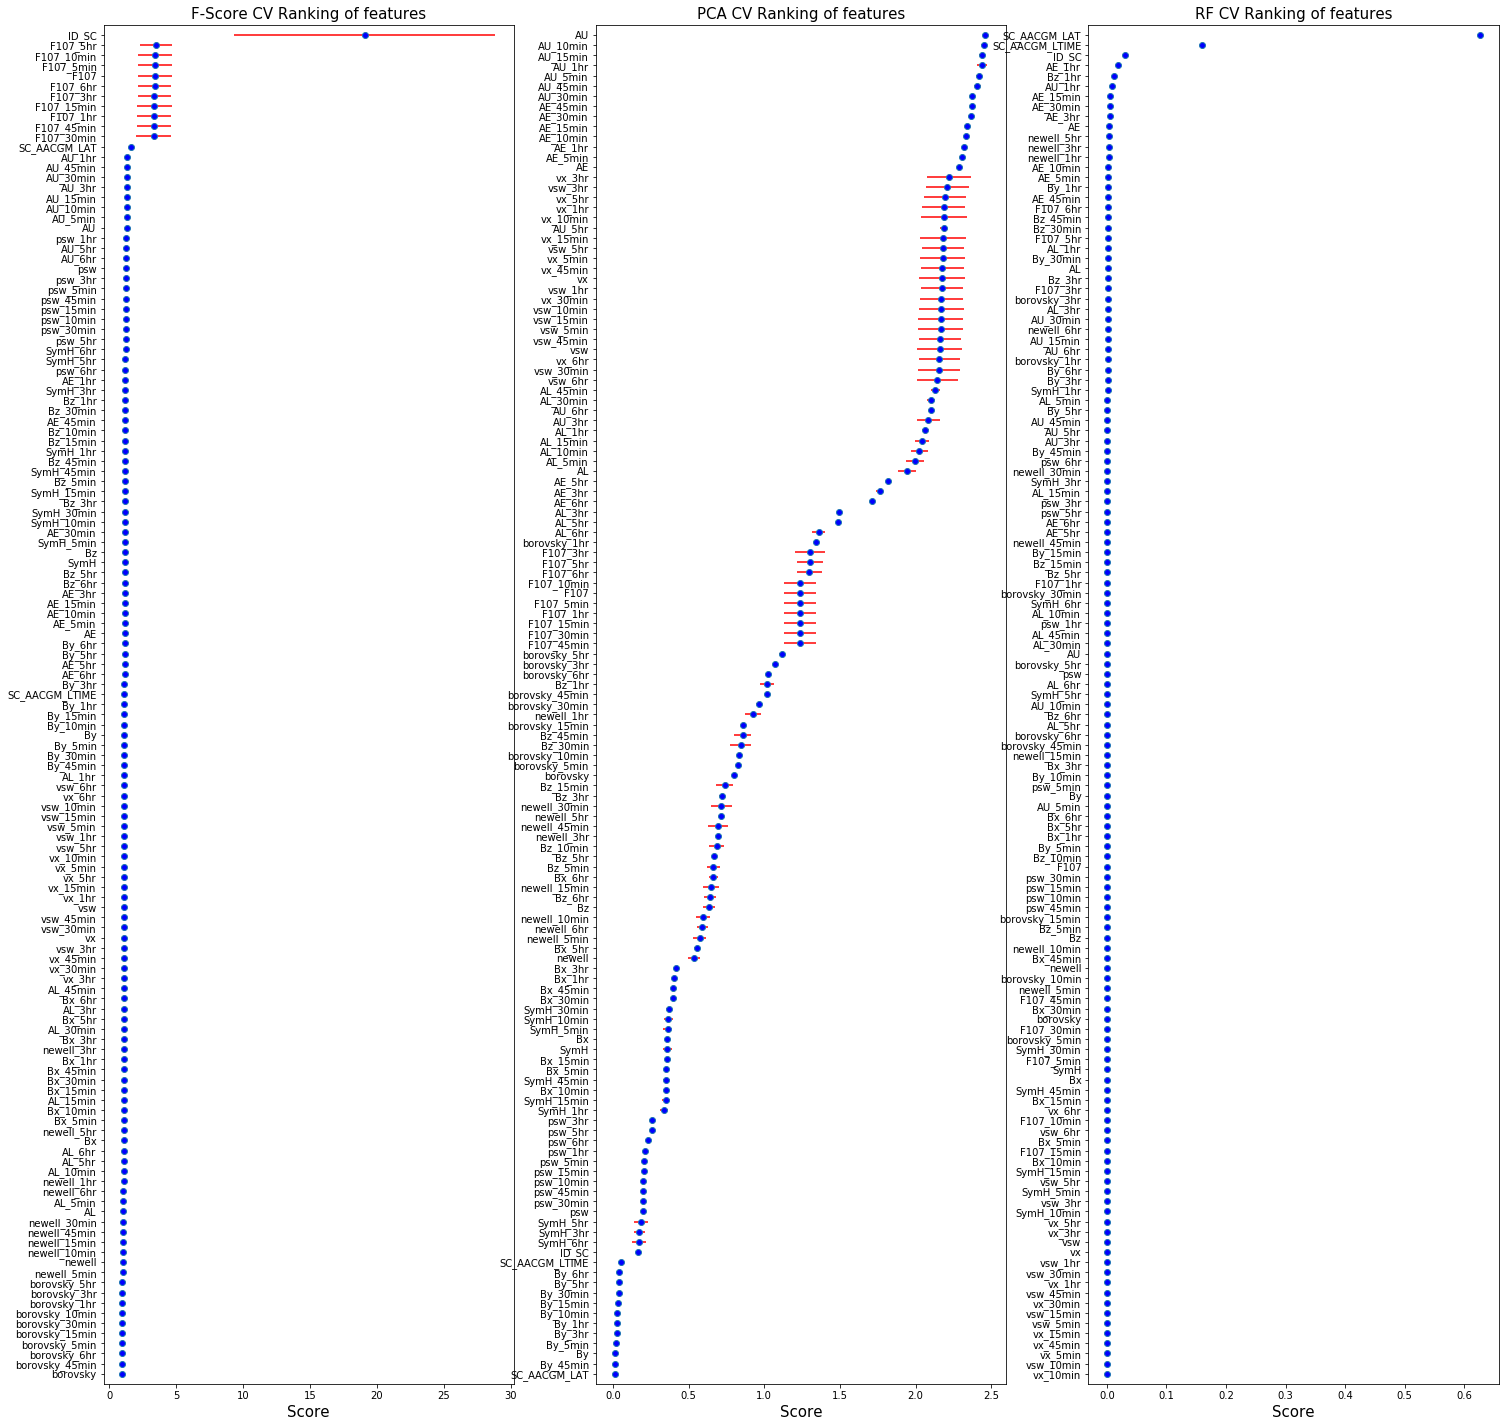

In [30]:
# With PC index removed

fig = plt.figure(figsize=(25,25))


# ----------------------------------------------------------------------------------------------------
# F SCORE
fscore_order = np.argsort(df_importance_noPC['median f score'])
fscore_orderedscores = [df_importance_noPC['median f score'][i] for i in fscore_order]
fscore_orderedvariances = [df_importance_noPC['variance f score'][i] for i in fscore_order]
# fscore_orderedfeaturelabels = [df_importance_noPC['feature'][i] for i in fscore_order]
fscore_orderedfeaturelabels = [df_importance_noPC.index[i] for i in fscore_order]
# [fscore_orderedfeaturelabels,fscore_orderedscores]


y_pos = np.arange(df_importance_noPC.shape[0])

plt.subplot(131)
plt.errorbar(fscore_orderedscores, 
             y_pos, 
             xerr=fscore_orderedvariances, 
             fmt='o',
             ecolor='r',
             mfc='b')
plt.ylim((-1, len(y_pos)))
plt.yticks(y_pos, fscore_orderedfeaturelabels)
plt.xlabel('Score', fontsize=15)
plt.title('F-Score CV Ranking of features', fontsize=15)
fig = plt.gcf()
#fig.savefig('features_FisherScores.png',bbox_inches='tight')
# ----------------------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------------------
# PCA SCORE
plt.subplot(132)
pca_order = np.argsort(df_importance_noPC['median pca'])
pca_orderedscores = [df_importance_noPC['median pca'][i] for i in pca_order]
pca_orderedvariances = [df_importance_noPC['variance pca'][i] for i in pca_order]
pca_orderedfeaturelabels = [df_importance_noPC.index[i] for i in pca_order]

plt.errorbar(pca_orderedscores, 
             y_pos, 
             xerr=pca_orderedvariances, 
             fmt='o',
             ecolor='r',
             mfc='b')
plt.ylim((-1, len(y_pos)))
plt.yticks(y_pos, pca_orderedfeaturelabels)
plt.xlabel('Score', fontsize=15)
plt.title('PCA CV Ranking of features', fontsize=15)
fig = plt.gcf()
#fig.savefig('features_FisherScores.png',bbox_inches='tight')
# ----------------------------------------------------------------------------------------------------

# ----------------------------------------------------------------------------------------------------
# RF SCORE
plt.subplot(133)
rf_order = np.argsort(df_importance_noPC['median rf'])
rf_orderedscores = [df_importance_noPC['median rf'][i] for i in rf_order]
rf_orderedvariances = [df_importance_noPC['variance rf'][i] for i in rf_order]
rf_orderedfeaturelabels = [df_importance_noPC.index[i] for i in rf_order]

plt.errorbar(rf_orderedscores, 
             y_pos, 
             xerr=rf_orderedvariances, 
             fmt='o',
             ecolor='r',
             mfc='b')
plt.ylim((-1, len(y_pos)))
plt.yticks(y_pos, rf_orderedfeaturelabels)
plt.xlabel('Score', fontsize=15)
plt.title('RF CV Ranking of features', fontsize=15)
fig = plt.gcf()
# ----------------------------------------------------------------------------------------------------

# fig.savefig(os.path.join(DMSP_FIGURE_DIR,'feature_importances_cumulative_up_to_'+str(df_importance_noPC['cumulative up to year'][0])+'_PCfixed.png'),bbox_inches='tight')





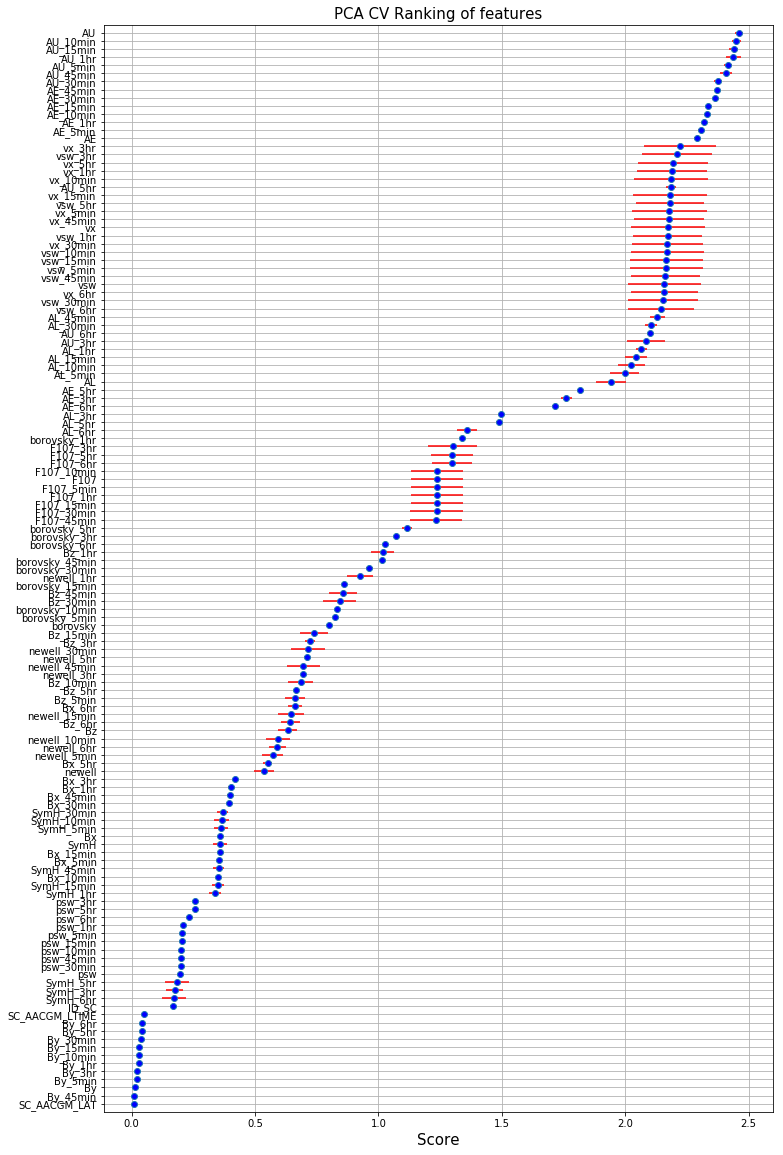

In [29]:
# PCA SCORE
plt.figure(figsize=(12,20))

y_pos = np.arange(df_importance_noPC.shape[0])

pca_order = np.argsort(df_importance_noPC['median pca'])
pca_orderedscores = [df_importance_noPC['median pca'][i] for i in pca_order]
pca_orderedvariances = [df_importance_noPC['variance pca'][i] for i in pca_order]
pca_orderedfeaturelabels = [df_importance_noPC.index[i] for i in pca_order]

plt.errorbar(pca_orderedscores, 
             y_pos, 
             xerr=pca_orderedvariances, 
             fmt='o',
             ecolor='r',
             mfc='b')
plt.ylim((-1, len(y_pos)))
plt.yticks(y_pos, pca_orderedfeaturelabels)
plt.xlabel('Score', fontsize=15)
plt.title('PCA CV Ranking of features', fontsize=15)
plt.grid(True)
fig = plt.gcf()

#fig.savefig('features_FisherScores.png',bbox_inches='tight')

In [2]:
f_score_norm = df_importance['median f score'].values / np.nanmax(df_importance['median f score'].values)
pca_score_norm = df_importance['median pca'].values / np.nanmax(df_importance['median pca'].values)
rf_score_norm = df_importance['median rf'].values / np.nanmax(df_importance['median rf'].values)

agg_score = np.nansum( (f_score_norm,pca_score_norm,rf_score_norm),axis=0 )

for l in range(10):
    print('{}: f = {}, pca = {}, rf = {} ---- agg = {}'.format(df_importance.index[l],
                                                               f_score_norm[l],
                                                               pca_score_norm[l],
                                                               rf_score_norm[l],
                                                               agg_score[l]))
    
fig = plt.figure(figsize=(15,25))
agg_order = np.argsort(agg_score)
agg_orderedscores = [agg_score[i] for i in agg_order]
agg_orderedfeaturelabels = [df_importance.index[i] for i in agg_order]

plt.errorbar(agg_orderedscores, 
             y_pos, 
             fmt='o',
#              ecolor='r',
             mfc='b')
plt.ylim((-1, len(y_pos)))
plt.yticks(y_pos, agg_orderedfeaturelabels)
plt.xlabel('Score', fontsize=15)
plt.title('Aggregate Ranking of features', fontsize=15)
plt.grid(True)
fig = plt.gcf()

fig.savefig(os.path.join(DMSP_FIGURE_DIR,'feature_importances_cumulative_up_to_2002_aggregate.png'),bbox_inches='tight')


NameError: name 'df_importance' is not defined

In [ ]:
## Determine top 20 features from combination of scores
df_fi['f score importance'][ (df_fi['f score importance'] == np.inf) | (df_fi['f score importance'] == -np.inf)] = np.nan
df_fi['PCA importance'][ (df_fi['PCA importance'] == np.inf) | (df_fi['PCA importance'] == -np.inf)] = np.nan
df_fi['random forest importance'][ (df_fi['random forest importance'] == np.inf) | (df_fi['random forest importance'] == -np.inf)] = np.nan

df_fi['f score importance norm'] = df_fi['f score importance'] / np.nanmax(df_fi['f score importance'])
df_fi['PCA importance norm'] = df_fi['PCA importance'] / np.nanmax(df_fi['PCA importance'])
df_fi['random forest importance norm'] = df_fi['random forest importance'] / np.nanmax(df_fi['random forest importance'])

In [189]:
agg_score = []
ctr = 0
for f in feature_labels:
    print(f)
    agg_score.append(np.nansum( (df_fi['f score importance norm'][df_fi['f score feature']==f].values,
                                 df_fi['PCA importance norm'][df_fi['PCA feature']==f].values,
                                 df_fi['random forest importance norm'][df_fi['random forest feature']==f].values),
                           ))
    
    print('feature = {}; agg score = {}'.format(f,agg_score[ctr]))
    ctr += 1
    
    

SC_AACGM_LAT
feature = SC_AACGM_LAT; agg score = 2.0149206536085416
SC_AACGM_LTIME
feature = SC_AACGM_LTIME; agg score = 0.7919546983710299
ID_SC
feature = ID_SC; agg score = 0.33872452952736437
F107
feature = F107; agg score = 1.2120664250074693
Bz
feature = Bz; agg score = 1.0427833740138563
By
feature = By; agg score = 1.1152004978268097
Bx
feature = Bx; agg score = 0.8535162811534154
AE
feature = AE; agg score = 1.1544043462611342
AL
feature = AL; agg score = 1.3649807476283855
AU
feature = AU; agg score = 1.1302029748867832
SymH
feature = SymH; agg score = 1.148089659725506
PC
feature = PC; agg score = 1.2353814368104357
vsw
feature = vsw; agg score = 1.002748382328896
vx
feature = vx; agg score = 1.003070166169241
psw
feature = psw; agg score = 1.247464192705319
borovsky
feature = borovsky; agg score = 1.0024915318692287
newell
feature = newell; agg score = 0.9442609166781555
F107_6hr
feature = F107_6hr; agg score = 1.2095949372033394
Bz_6hr
feature = Bz_6hr; agg score = 1.066111

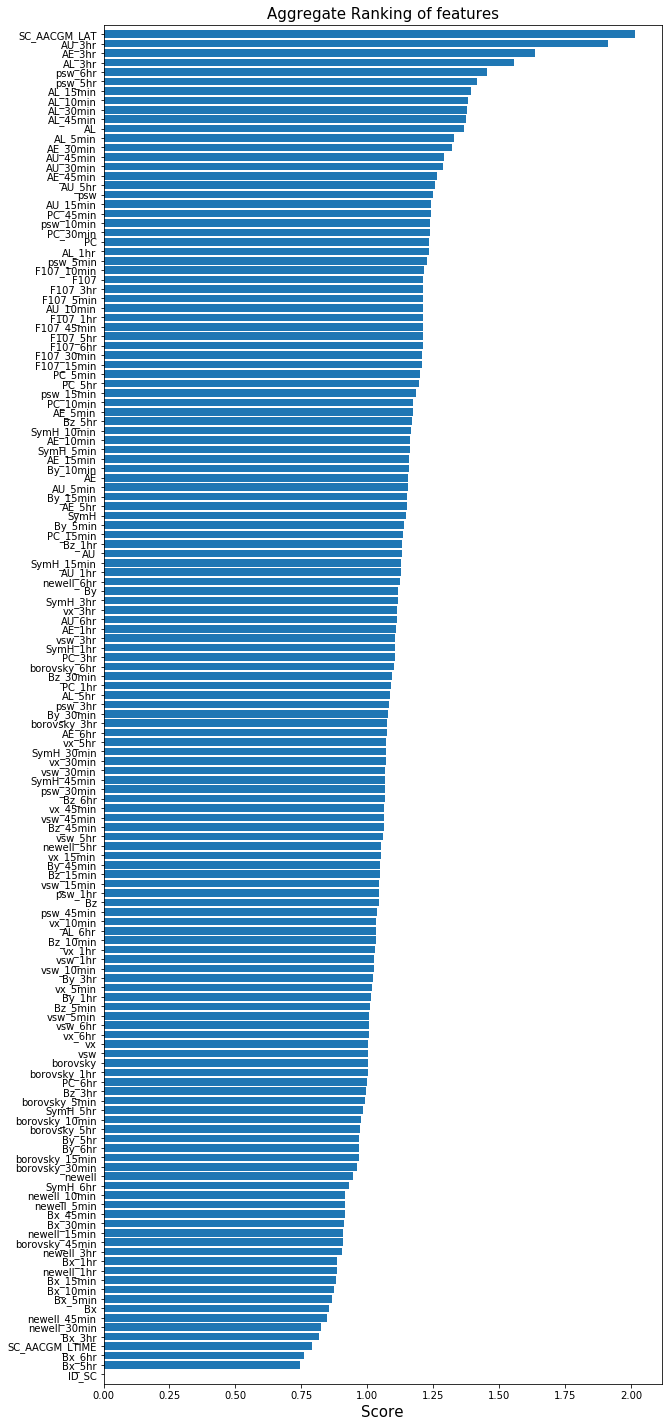

In [194]:
agg_order = np.argsort(agg_score)
agg_orderedscores = [agg_score[i] for i in agg_order]
agg_orderedscores[ (agg_orderedscores == np.inf) | (agg_orderedscores == -np.inf)] = np.nan
agg_orderedfeaturelabels = [feature_labels[i] for i in agg_order]

fig = plt.figure(figsize=(10,25))

# F-Score
plt.barh(y_pos, agg_orderedscores, align='center')
plt.ylim((-1, len(y_pos)))
plt.yticks(y_pos, agg_orderedfeaturelabels)
plt.xlabel('Score', fontsize=15)
plt.title('Aggregate Ranking of features', fontsize=15)
fig = plt.gcf()
#fig.savefig('features_FisherScores.png',bbox_inches='tight')

